In [1]:
import pickle 
import torch
import torch.nn as nn
import numpy as np
import sys
import random
import optuna
sys.path.append('../../..')
sys.path.append('../../../ml_mmrf/')
from data import load_mmrf
sys.path.append('../../../..')
sys.path.append('../../../../models/')
from ssm.ssm import SSM, SSMAtt
from utils import *
from torch.utils.data import DataLoader, TensorDataset
from numpy.random import choice 

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

## alternate font/graph format
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
plt.rc('font', weight='heavy')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('axes', labelsize='x-large')

/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
fold = 1
ddata = load_mmrf(fold_span = [fold], \
                              digitize_K = 0, \
                              digitize_method = 'uniform', \
                              suffix='_2mos_tr', \
#                               restrict_markers=['serum_m_protein', 'syn_marker'], \
                              restrict_markers=[], \
                              add_syn_marker=True, \
                              window='first_second', \
                              data_aug=False)
print(ddata.keys())
print(ddata[1]['train']['feature_names_x'])

loading from: /afs/csail.mit.edu/u/z/zeshanmh/research/longlearn/data/ml_mmrf/ml_mmrf/ml_mmrf_v1/cleaned_mm_fold_2mos_tr.pkl
adding synthetic marker in fold 1, set train...
new shape of X: (212, 36, 8)
new shape of M: (212, 36, 8)
adding synthetic marker in fold 1, set valid...
new shape of X: (71, 36, 8)
new shape of M: (71, 36, 8)
adding synthetic marker in fold 1, set test...
new shape of X: (96, 36, 8)
new shape of M: (96, 36, 8)
{'MMRF_1866', 'MMRF_1064', 'MMRF_1951', 'MMRF_2225'}
dict_keys([1])
['serum_kappa' 'serum_m_protein' 'serum_iga' 'serum_igg' 'serum_igm'
 'serum_lambda' 'urine_24hr_m_protein' 'syn_marker']


In [4]:
split = 'train'
X = ddata[1][split]['x']
M = ddata[1][split]['m']
A = ddata[1][split]['a']
Y = ddata[1][split]['ys_seq']
print(ddata[1][split]['feature_names_x'])
print(X.shape)
pd_idxs = np.where(Y==1)[0]
nonpd_idxs = np.where(Y==0)[0]
print(len(pd_idxs))
print(len(nonpd_idxs))
print(A[1,:,-2])
xfeats = ddata[1][split]['feature_names_x'].tolist()
midx = xfeats.index('serum_m_protein')
kidx = xfeats.index('serum_kappa')
lidx = xfeats.index('serum_lambda')
umidx = xfeats.index('urine_24hr_m_protein')
# spd = xfeats.index('SERUMMCOMPONE')
# upd = xfeats.index('URINEMCOMPONE')
# inpd = xfeats.index('ONLYINPATIENT')
# inpd2 = xfeats.index('ONLYINPATIENT2')
# devpd = xfeats.index('DEVELOPMENTOF')
smidx= xfeats.index('syn_marker')
print(midx)
print(ddata[1][split]['pids'])
print([(idx,x) for idx,x in enumerate(ddata[1][split]['pids']) if x == 'MMRF_1890'])
# print(A[126,:])
# print(Y[126])
print(pd_idxs)
print(M[7,:,-1]) # masking of synthetic marker is wrong!!! 


['serum_kappa' 'serum_m_protein' 'serum_iga' 'serum_igg' 'serum_igm'
 'serum_lambda' 'urine_24hr_m_protein' 'syn_marker']
(212, 36, 8)
93
119
[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1
['MMRF_2225' 'MMRF_1090' 'MMRF_1927' 'MMRF_1917' 'MMRF_1491' 'MMRF_1951'
 'MMRF_2386' 'MMRF_1518' 'MMRF_1933' 'MMRF_2608' 'MMRF_1629' 'MMRF_1929'
 'MMRF_2305' 'MMRF_2185' 'MMRF_2388' 'MMRF_1202' 'MMRF_2317' 'MMRF_1408'
 'MMRF_1533' 'MMRF_2087' 'MMRF_2001' 'MMRF_1213' 'MMRF_2026' 'MMRF_1625'
 'MMRF_1866' 'MMRF_1335' 'MMRF_2072' 'MMRF_1670' 'MMRF_1354' 'MMRF_1224'
 'MMRF_2091' 'MMRF_1377' 'MMRF_1149' 'MMRF_1504' 'MMRF_2250' 'MMRF_2211'
 'MMRF_1555' 'MMRF_2478' 'MMRF_1541' 'MMRF_1936' 'MMRF_1210' 'MMRF_1359'
 'MMRF_1479' 'MMRF_1596' 'MMRF_1717' 'MMRF_2336' 'MMRF_1122' 'MMRF_2589'
 'MMRF_2310' 'MMRF_1837' 'MMRF_2257' 'MMRF_2204' 'MMRF_1143' 'MMRF_2330'
 'MMRF_2194' 'MMRF_1264' 'MMRF_2064' 'MMRF_1511' 'MMRF_1269' 'MMRF_1084'
 'MMRF_1876' 'M

No handles with labels found to put in legend.


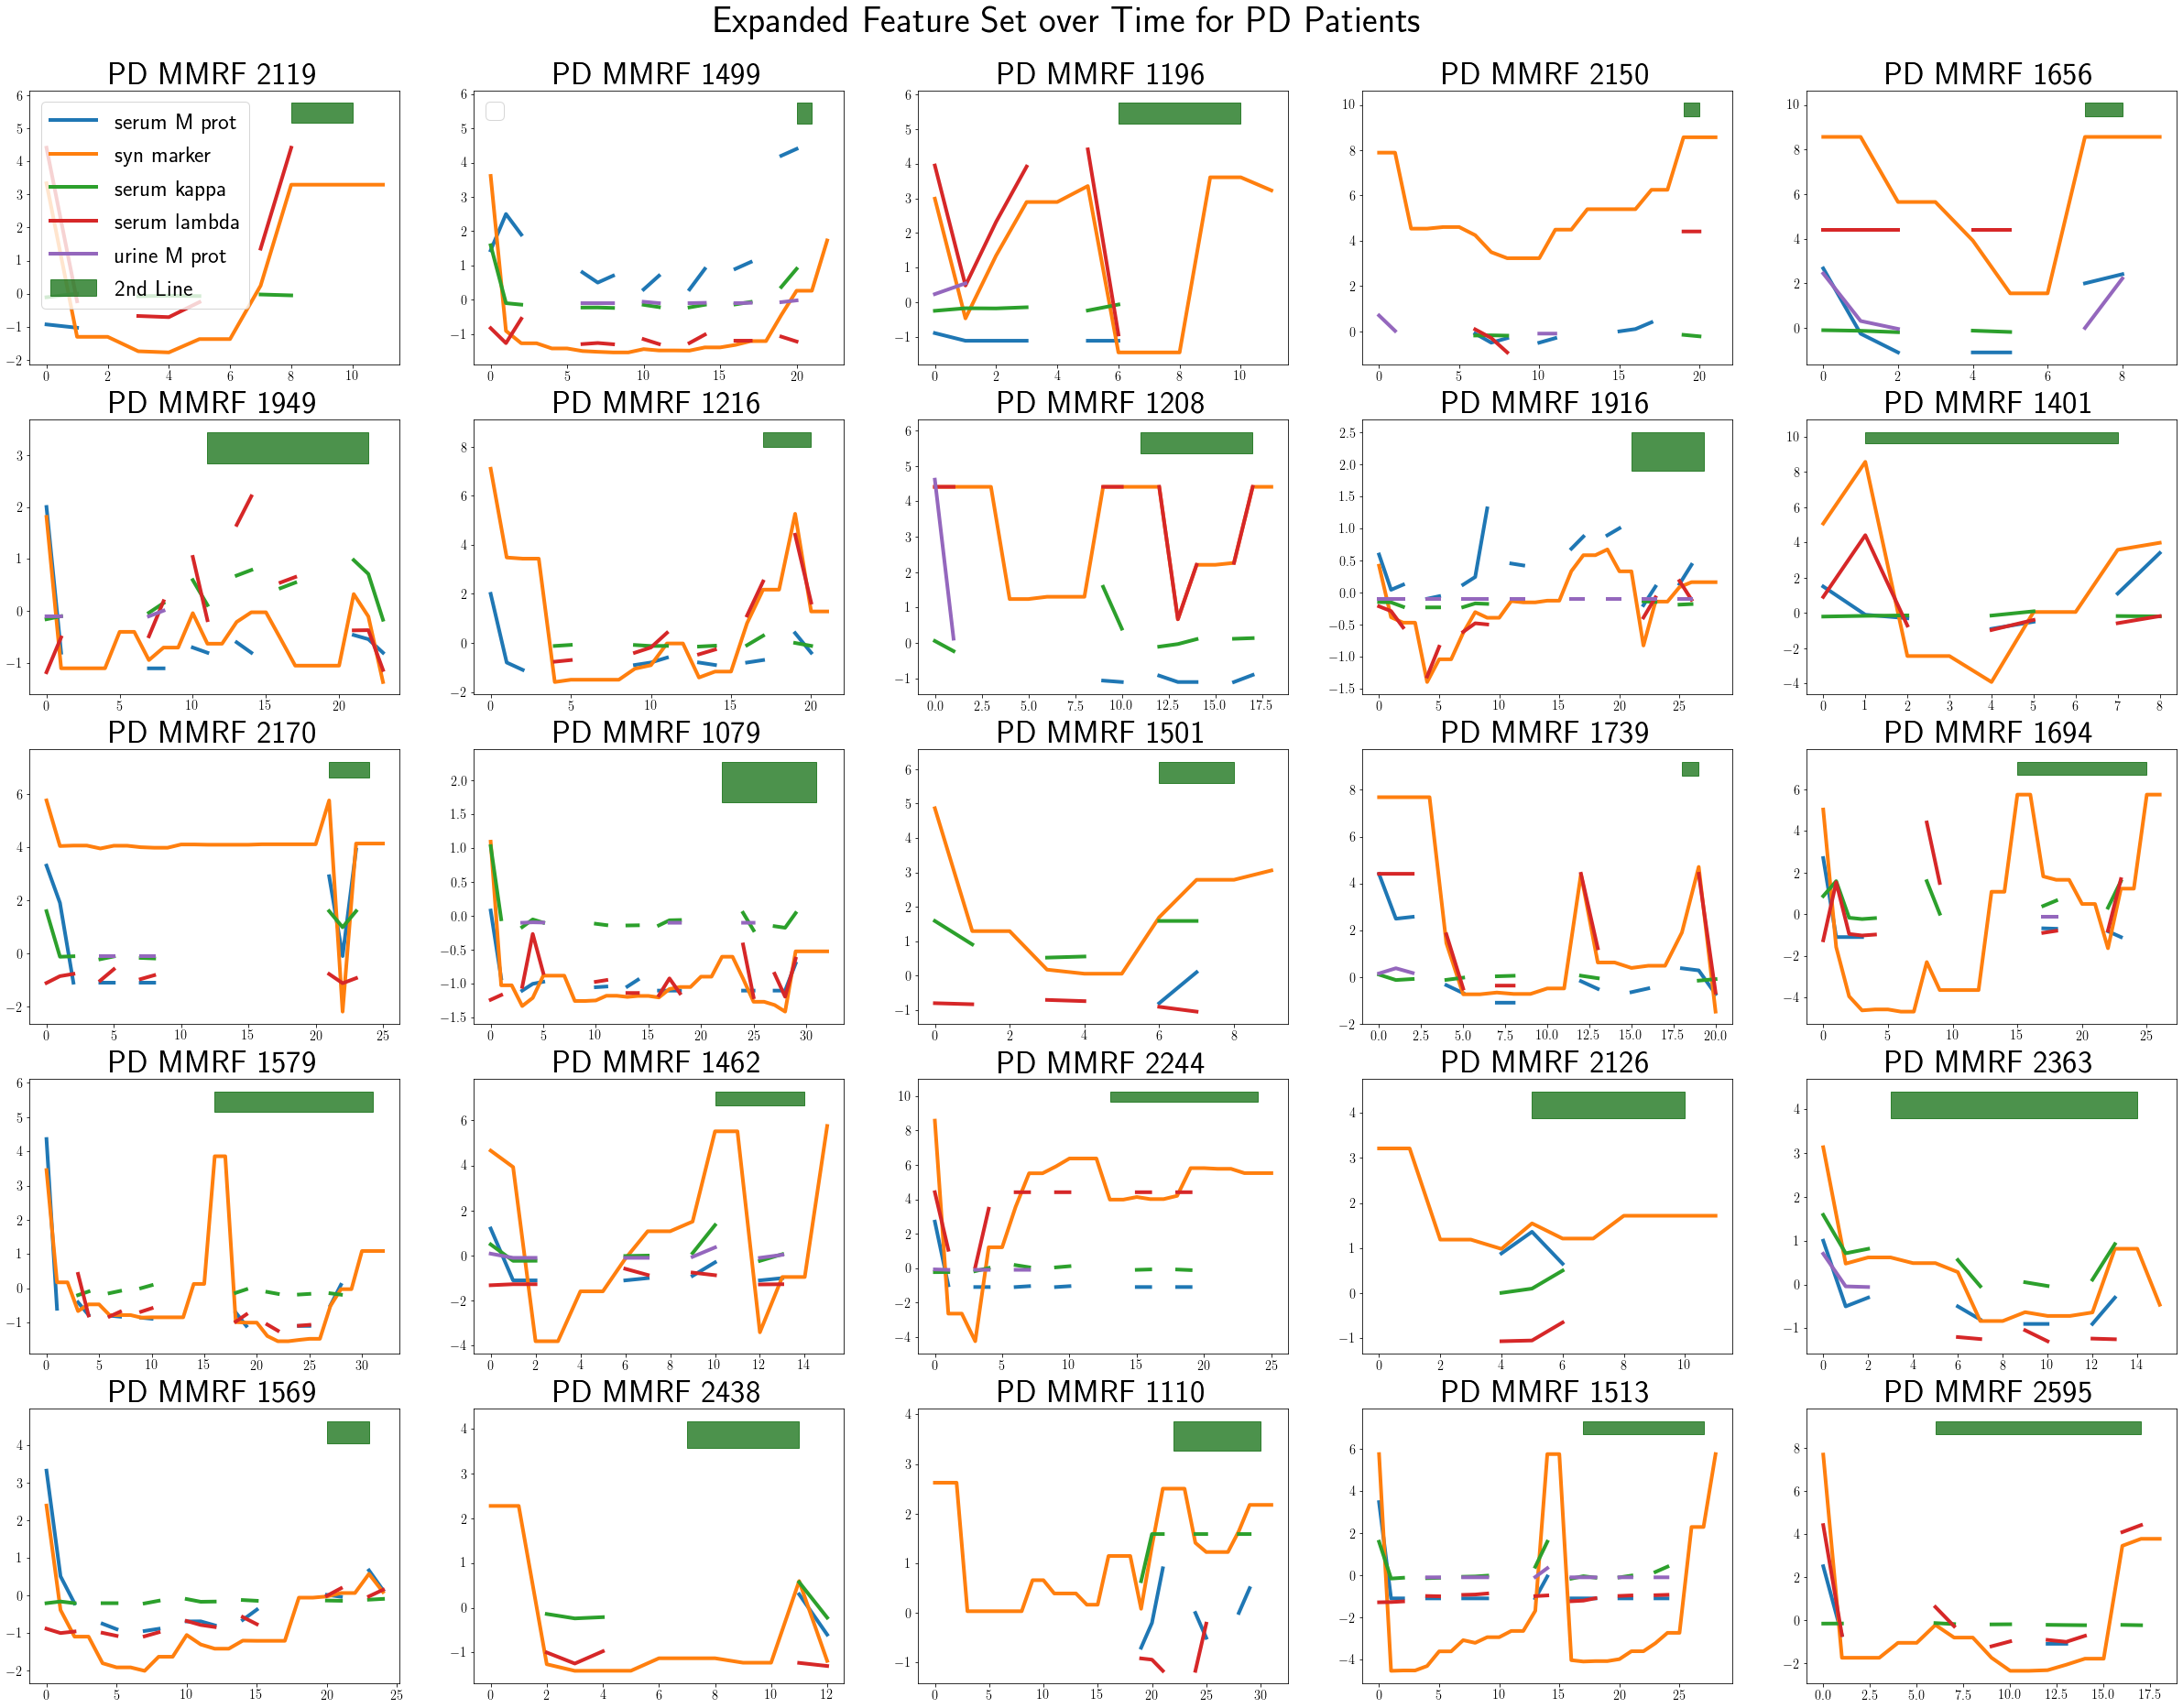

In [5]:
fig, axlist = plt.subplots(5,5,figsize=(42,32))
ax         = axlist.ravel()
for i,idx in enumerate(pd_idxs[50:75]): 
#     if ddata[1][split]['pids'][idx] == 'MMRF_1842':
#         import pdb; pdb.set_trace()
    second_line = A[idx,:,-2]
    sline_ts  = np.where(second_line == 1.)[0]
    if len(sline_ts) != 0: 
        sline_ts  = np.concatenate((sline_ts,[sline_ts[-1]+1]))
    orig_example = X[idx]
    orig_example[np.where(M[idx] == 0.)] = np.nan
    if i == 0: 
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,midx], linewidth=4, label='serum M prot')
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,smidx], linewidth=4, label='syn marker')
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,kidx], linewidth=4, label='serum kappa')
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,lidx], linewidth=4, label='serum lambda')
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,umidx], linewidth=4, label='urine M prot')
        ymax = ax[i].get_ylim()[1]+0.05
        ys = np.array([ymax for x in range(len(sline_ts))])
        ax[i].fill_between(sline_ts, ys+0.4,ys+1., color='darkgreen', alpha=0.7, label='2nd Line')
    else: 
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,midx], linewidth=4)
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,smidx], linewidth=4)
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,kidx], linewidth=4)
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,lidx], linewidth=4)
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,umidx], linewidth=4)
        ymax = ax[i].get_ylim()[1]+0.05
        ys = np.array([ymax for x in range(len(sline_ts))])
        ax[i].fill_between(sline_ts, ys+0.4,ys+1., color='darkgreen', alpha=0.7)

#     ymax = ax[i].get_ylim()[1]+0.05
#     ys = np.array([ymax for x in range(len(sline_ts))])
#     spd_idxs = np.where(orig_example[:,spd] == 1.)[0]
#     upd_idxs = np.where(orig_example[:,upd] == 1.)[0]
#     inpd_idxs = np.where(orig_example[:,inpd] == 1.)[0]
#     inpd2_idxs = np.where(orig_example[:,inpd2] == 1.)[0]
#     devpd_idxs = np.where(orig_example[:,devpd] == 1.)[0]    
#     if i == 1:
#         ax[i].scatter(spd_idxs,[ymax+1.4 for x in range(len(spd_idxs))],s=65, label='serum M PD')
#         ax[i].scatter(upd_idxs,[ymax+1.7 for x in range(len(upd_idxs))],s=65, label='urine M PD')
#         ax[i].scatter(inpd_idxs,[ymax+2. for x in range(len(inpd_idxs))],s=65, label='FLC PD')
#         ax[i].scatter(inpd2_idxs,[ymax+2.3 for x in range(len(inpd2_idxs))],s=65, label='Bone Marrow PC PD')
#         ax[i].fill_between(sline_ts, ys+0.4,ys+1., color='darkgreen', alpha=0.7, label='2nd Line')
#     else: 
#         ax[i].scatter(spd_idxs,[ymax+1.4 for x in range(len(spd_idxs))],s=65)
#         ax[i].scatter(upd_idxs,[ymax+1.7 for x in range(len(upd_idxs))],s=65)
#         ax[i].scatter(inpd_idxs,[ymax+2. for x in range(len(inpd_idxs))],s=65)
#         ax[i].scatter(inpd2_idxs,[ymax+2.3 for x in range(len(inpd2_idxs))],s=65)
#         ax[i].fill_between(sline_ts, ys+0.4,ys+1., color='darkgreen', alpha=0.7)
        
#     ax[i].scatter(devpd_idxs,[ymax+2.6 for x in range(len(devpd_idxs))],s=65, label='Calcium PD')
    s = ddata[1][split]['pids'][idx].split('_')[1]
    ax[i].set_title(f'PD MMRF {s}', fontsize=35)
    if i == 0 or i == 1: 
        ax[i].legend(fontsize=25, loc='upper left')
fig.suptitle('Expanded Feature Set over Time for PD Patients', fontsize=40, y=0.92)
fig.savefig(f'restricted_feat_pds_expanded.pdf',bbox_inches='tight')

In [9]:
print(nonpd_idxs)
final_nonpd_idxs= nonpd_idxs[75:100]
print(final_nonpd_idxs)
print(len(ddata[1][split]['pids']))
print(len(nonpd_idxs))
print(len(pd_idxs))
# print(ddata[1][split]['pids'][112])
# print(ddata[1][split]['pids'][100])
# print(ddata[1][split]['pids'][89])
# print(ddata[1][split]['pids'][152])
# i = ddata[1][split]['pids'].tolist().index('MMRF_2306')
# print(A[i])
# print(pd_idxs)

[  1   4   5   6   7   9  10  12  14  15  16  18  27  28  30  33  34  35
  37  39  40  44  45  49  50  51  52  53  54  55  56  61  62  63  64  65
  68  69  71  73  74  77  79  80  84  86  87  88  89  90  93  94 100 101
 102 103 104 105 106 108 110 112 113 114 116 117 119 120 121 122 124 125
 126 127 129 131 132 133 134 135 136 137 138 139 140 142 145 146 147 149
 150 157 158 160 163 164 169 170 171 174 178 179 180 181 183 186 193 194
 195 196 197 198 201 202 205 206 207 208 209]
[131 132 133 134 135 136 137 138 139 140 142 145 146 147 149 150 157 158
 160 163 164 169 170 171 174]
212
119
93


No handles with labels found to put in legend.


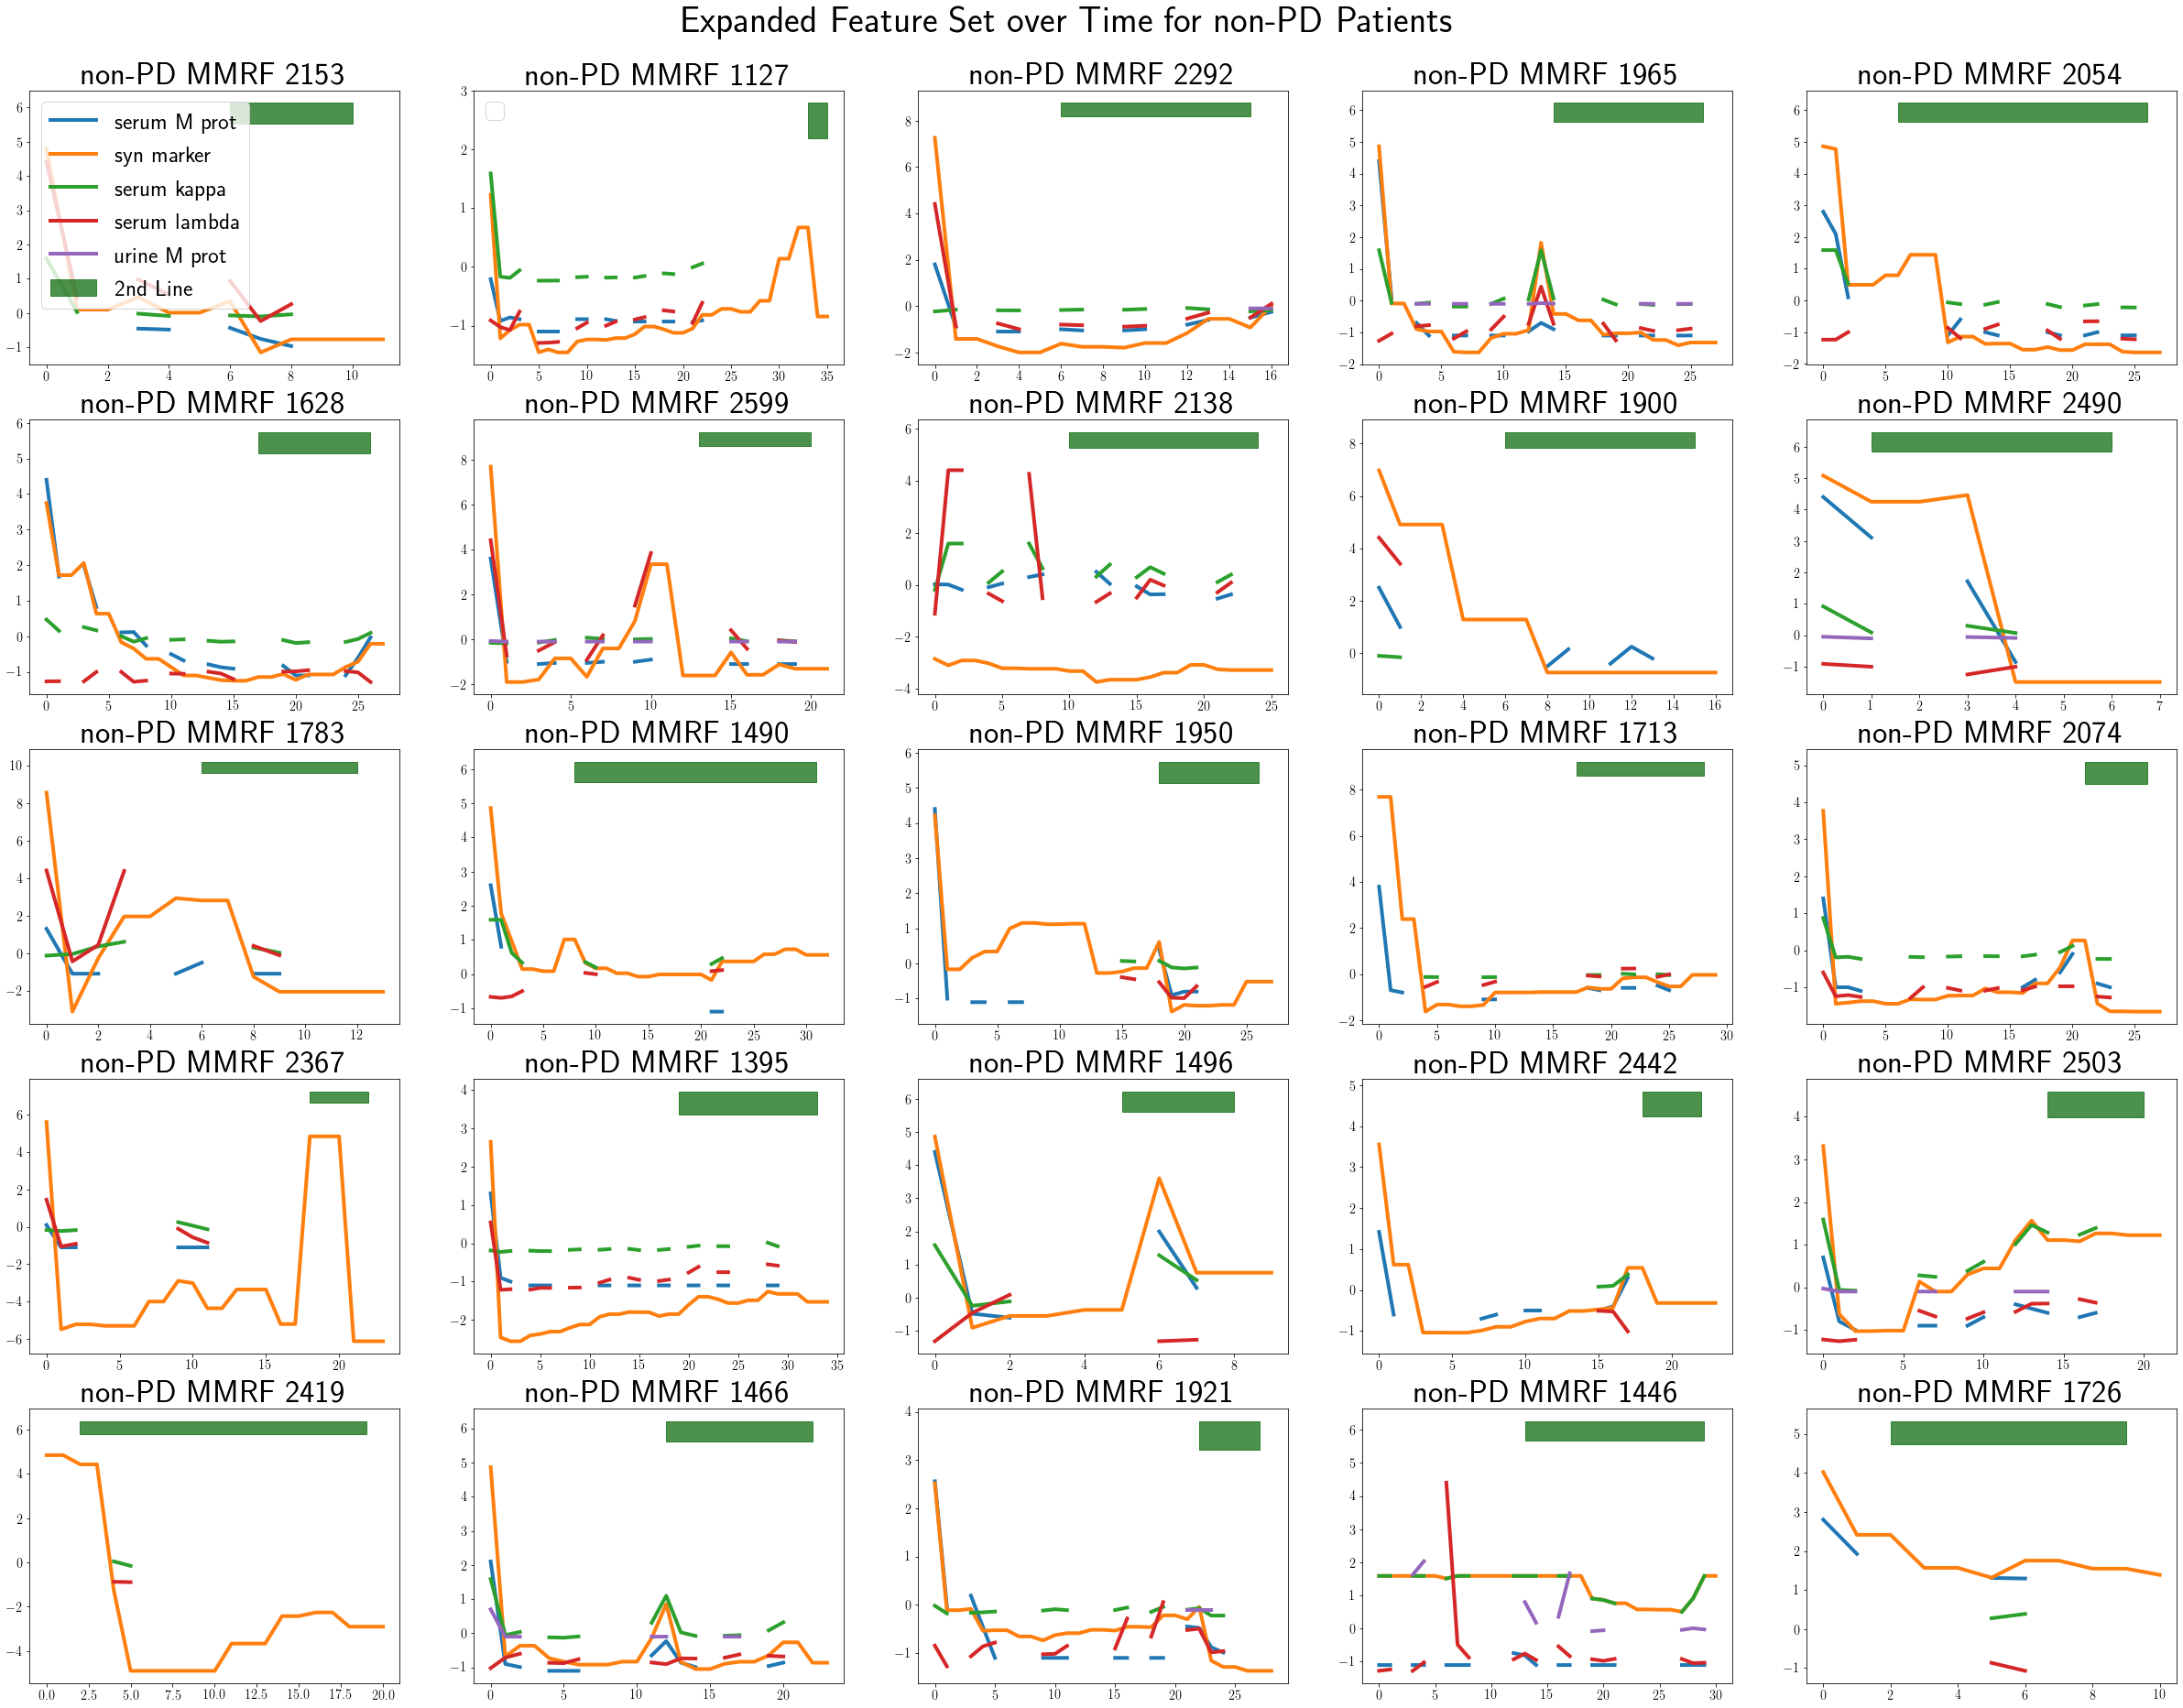

In [11]:
# np.random.shuffle(nonpd_idxs)
fig, axlist = plt.subplots(5,5,figsize=(42,32))
ax         = axlist.ravel()
for i,idx in enumerate(final_nonpd_idxs): 
    second_line = A[idx,:,-2]
    sline_ts  = np.where(second_line == 1.)[0]
    if len(sline_ts) != 0: 
        sline_ts  = np.concatenate((sline_ts,[sline_ts[-1]+1]))
    orig_example = X[idx]
    orig_example[np.where(M[idx] == 0.)] = np.nan
    if i == 0: 
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,midx], linewidth=4, label='serum M prot')
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,smidx], linewidth=4, label='syn marker')
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,kidx], linewidth=4, label='serum kappa')
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,lidx], linewidth=4, label='serum lambda')
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,umidx], linewidth=4, label='urine M prot')
        ymax = ax[i].get_ylim()[1]+0.05
        ys = np.array([ymax for x in range(len(sline_ts))])
        ax[i].fill_between(sline_ts, ys+0.4,ys+1., color='darkgreen', alpha=0.7, label='2nd Line')
    else: 
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,midx], linewidth=4)
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,smidx], linewidth=4)
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,kidx], linewidth=4)
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,lidx], linewidth=4)
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,umidx], linewidth=4)
        ymax = ax[i].get_ylim()[1]+0.05
        ys = np.array([ymax for x in range(len(sline_ts))])
        ax[i].fill_between(sline_ts, ys+0.4,ys+1., color='darkgreen', alpha=0.7)

#     ymax = ax[i].get_ylim()[1]+0.05
#     ys = np.array([ymax for x in range(len(sline_ts))])
#     spd_idxs = np.where(orig_example[:,spd] == 1.)[0]
#     upd_idxs = np.where(orig_example[:,upd] == 1.)[0]
#     inpd_idxs = np.where(orig_example[:,inpd] == 1.)[0]
#     inpd2_idxs = np.where(orig_example[:,inpd2] == 1.)[0]
#     devpd_idxs = np.where(orig_example[:,devpd] == 1.)[0]    
#     if i == 1:
#         ax[i].scatter(spd_idxs,[ymax+1.4 for x in range(len(spd_idxs))],s=65, label='serum M PD')
#         ax[i].scatter(upd_idxs,[ymax+1.7 for x in range(len(upd_idxs))],s=65, label='urine M PD')
#         ax[i].scatter(inpd_idxs,[ymax+2. for x in range(len(inpd_idxs))],s=65, label='FLC PD')
#         ax[i].scatter(inpd2_idxs,[ymax+2.3 for x in range(len(inpd2_idxs))],s=65, label='Bone Marrow PC PD')
#         ax[i].fill_between(sline_ts, ys+0.4,ys+1., color='darkgreen', alpha=0.7, label='2nd Line')
#     else: 
#         ax[i].scatter(spd_idxs,[ymax+1.4 for x in range(len(spd_idxs))],s=65)
#         ax[i].scatter(upd_idxs,[ymax+1.7 for x in range(len(upd_idxs))],s=65)
#         ax[i].scatter(inpd_idxs,[ymax+2. for x in range(len(inpd_idxs))],s=65)
#         ax[i].scatter(inpd2_idxs,[ymax+2.3 for x in range(len(inpd2_idxs))],s=65)
#         ax[i].fill_between(sline_ts, ys+0.4,ys+1., color='darkgreen', alpha=0.7)
    ax[i].set_title(f'non-PD MMRF {ddata[1][split]["pids"][idx].split("_")[1]}', fontsize=35)
    if i == 0 or i == 1: 
        ax[i].legend(fontsize=25, loc='upper left')
fig.suptitle('Expanded Feature Set over Time for non-PD Patients', fontsize=40, y=0.92)
fig.savefig(f'restricted_feat_nonpds_expanded.pdf',bbox_inches='tight')

In [56]:
# additive shifts 
def add_shift_tf(ddata,idx,typep='PD'): 
    fig, axlist = plt.subplots(11,1,figsize=(12,52))
    ax         = axlist.ravel()
    X = ddata[1]['train']['x'][[idx]]
    ax[0].plot(np.arange(X.shape[1]), X[0,:,0], linewidth=4)
    ax[0].plot(np.arange(X.shape[1]), X[0,:,1], linewidth=4)
    ax[0].set_title(f'original {typep} patient', fontsize=25)
    print(X)
    nsamples = 10*X.shape[0]
    Xnew     = np.zeros((nsamples,X.shape[1],X.shape[2]))
    for i in range(10):
        shift_factor = np.random.uniform(-4,4,size=X.shape[0])
        print(shift_factor)
        print(X+shift_factor)
        Xnew[i*X.shape[0]:(i+1)*X.shape[0]] = X+shift_factor
        
    for idx in range(Xnew.shape[0]): 
        orig_example = Xnew[idx]
        orig_example[np.where(M[idx] == 0.)] = np.nan
        ax[idx+1].plot(np.arange(orig_example.shape[0]), orig_example[:,0], linewidth=4)
        ax[idx+1].plot(np.arange(orig_example.shape[0]), orig_example[:,1], linewidth=4)
        ax[idx+1].set_title(f'{typep} patient {idx+1}', fontsize=25)
    return Xnew
        
# scaling in y direction
def scale_y_tf(ddata,idx,typep='PD'): 
    fig, axlist = plt.subplots(11,1,figsize=(12,52))
    ax         = axlist.ravel()
    X = ddata[1]['train']['x'][[idx]]
    ax[0].plot(np.arange(X.shape[1]), X[0,:,0], linewidth=4)
    ax[0].plot(np.arange(X.shape[1]), X[0,:,1], linewidth=4)
    ax[0].set_title(f'original {typep} patient', fontsize=25)
    print(X)
    nsamples = 10*X.shape[0]
    Xnew = np.zeros((nsamples,X.shape[1],X.shape[2]))
    for i in range(10): 
        scale_factor = np.random.uniform(1,3,size=X.shape[0])
        print(scale_factor)
#         print(X*scale_factor)
        Xnew[i*X.shape[0]:(i+1)*X.shape[0]] = X*scale_factor
    
    for idx in range(Xnew.shape[0]): 
        orig_example = Xnew[idx]
        orig_example[np.where(M[idx] == 0.)] = np.nan
        ax[idx+1].plot(np.arange(orig_example.shape[0]), orig_example[:,0], linewidth=4)
        ax[idx+1].plot(np.arange(orig_example.shape[0]), orig_example[:,1], linewidth=4)
        ax[idx+1].set_title(f'{typep} patient {idx+1}', fontsize=25)
    return Xnew



[[[ 3.57999992  4.87899995]
  [ 1.71999991  3.05049992]
  [ 0.10000002  0.38125006]
  [ 0.10000002  0.38125006]
  [ 0.49000001  1.03374991]
  [ 1.20999992  2.07975012]
  [ 1.20999992  2.07975012]
  [-0.10000002  0.19575003]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]]]
[2.85130569]
[1.83090009]
[1.55404922]
[2.7762327]
[2.1512585]
[1.54882943

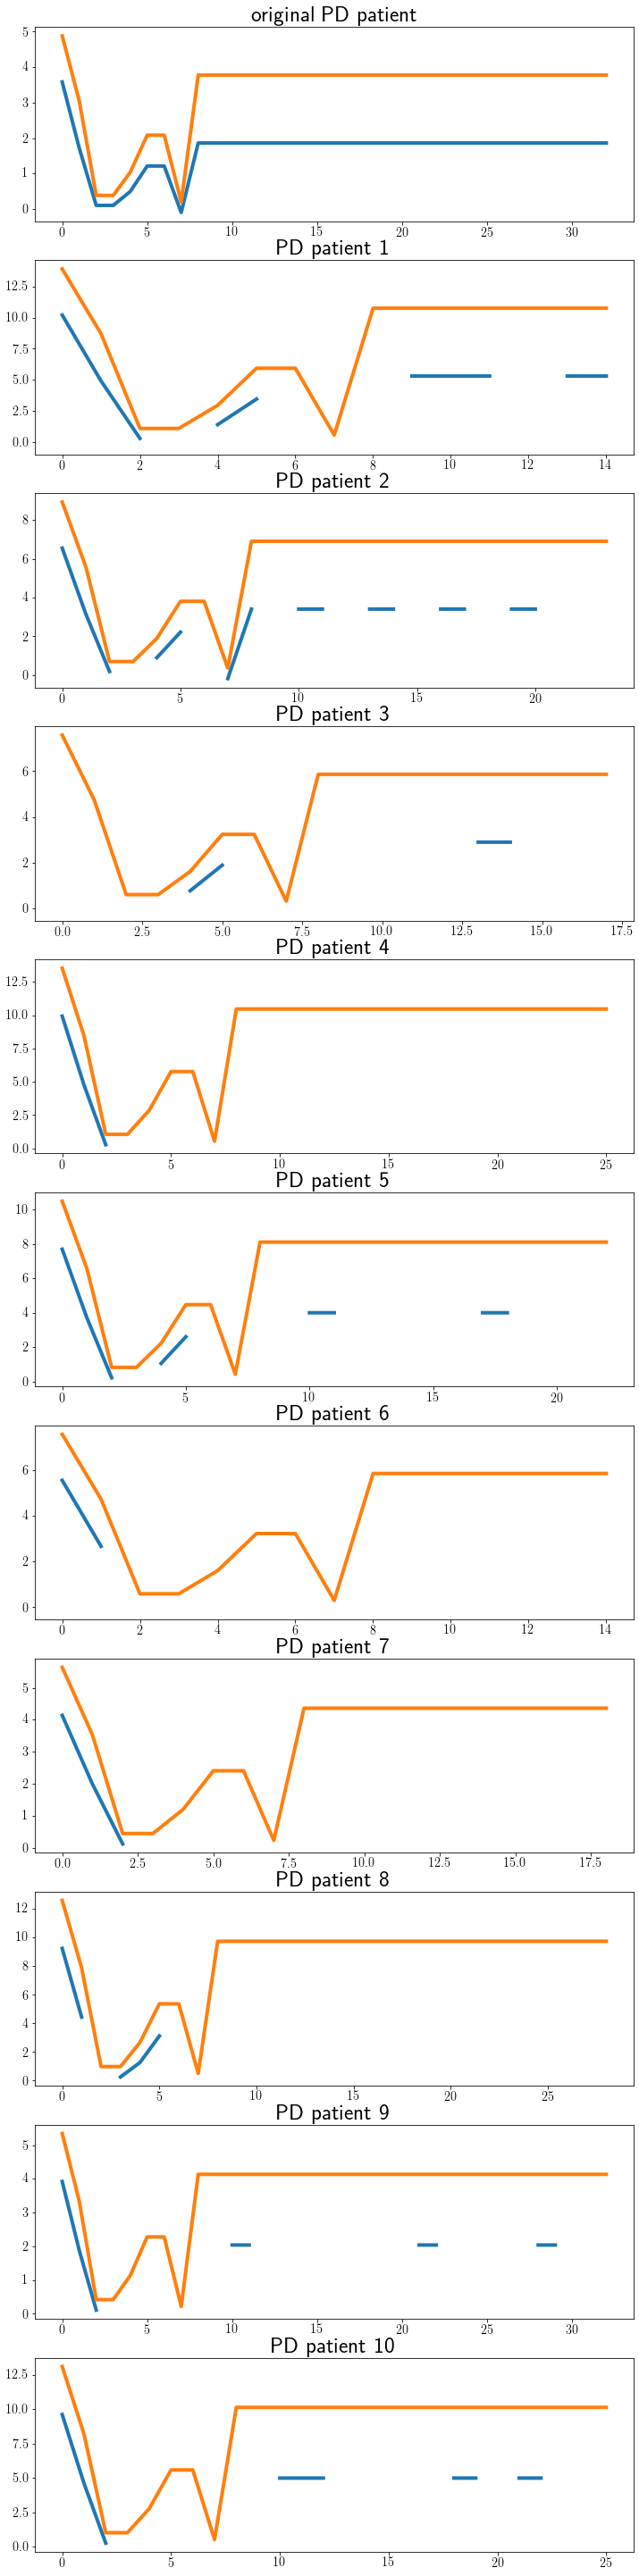

In [58]:
Xnew = scale_y_tf(ddata,pd_idxs[10],typep='PD')